In [16]:
import os, datetime
import pandas as pd
import numpy as np
from prophet import Prophet

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Set the maximum number of row to be displayed
pd.options.display.max_rows = 100

In [17]:
col1 = ["Average_Price", "Average_Price_SA"]
col2 = ["Monthly_Change", "Annual_Change"]
NEW_PATH = os.path.join(Path.cwd().parents[2],"data","uk_house_price")

print(NEW_PATH)

d:\github_repos\mlops-zoomcamp\data\uk_house_price


## Open file `Average-prices-2022-06.csv`

In [18]:
DATA_PATH = os.path.join(NEW_PATH, 'Average-prices-2022-06.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
0,1968-04-01,England,E92000001,3408.108064,0.0,NaN,NaN
1,1968-04-01,Scotland,S92000003,2844.980688,0.0,NaN,NaN
2,1968-04-01,Northern Ireland,N92000001,3661.485500,0.0,NaN,NaN
3,1968-04-01,Wales,W92000004,2885.414162,0.0,NaN,NaN
4,1968-04-01,West Midlands Region,E12000005,3328.858802,0.0,NaN,NaN


In [19]:
### Scaling down data by truncating rows with previous dates up to 1994-31-12
df[df['Date'].str[:4].isin(['1995'])].head()

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
3309,1995-01-01,Wales,W92000004,43164.30827,NaN,6.222901,43031.70419
3310,1995-01-01,Scotland,S92000003,40321.50730,-4.150198,-0.614754,NaN
3311,1995-01-01,England,E92000001,53202.77128,NaN,1.387601,53535.97105
3312,1995-01-01,Northern Ireland,N92000001,42280.84358,5.909511,10.714286,NaN
3313,1995-01-01,Inner London,E13000001,78251.97650,NaN,NaN,NaN


In [23]:
df2 = df[3309:]
df2.to_csv('Average_price-2022-06_from1995.csv')

In [ ]:
DATA_PATH = os.path.join(NEW_PATH, 'Average_price-2022-06_from1995.csv')
df = pd.read_csv(DATA_PATH)
df2 = df.drop("Unnamed: 0", axis=1)
df2["Date"] = pd.to_datetime(df2.Date)
df2[col1] = df2[col1].astype("float32")
df2[col2] = df2[col2].astype("float16")

df2.head()

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
0,1995-01-01,Wales,W92000004,43164.308594,NaN,6.222656,43031.703125
1,1995-01-01,Scotland,S92000003,40321.507812,-4.148438,-0.614746,NaN
2,1995-01-01,England,E92000001,53202.769531,NaN,1.387695,53535.972656
3,1995-01-01,Northern Ireland,N92000001,42280.843750,5.910156,10.710938,NaN
4,1995-01-01,Inner London,E13000001,78251.976562,NaN,NaN,NaN


In [ ]:
df2.describe()

,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
count,1.340460e+05,133604.000000,129162.000000,4614.000000
mean,1.719118e+05,NaN,NaN,158859.359375
std,1.127025e+05,0.000000,0.000000,82419.164062
min,2.310073e+04,-30.296875,-35.781250,40405.312500
25%,9.983071e+04,-0.427490,1.482422,110191.179688
50%,1.500298e+05,0.519043,5.589844,149161.406250
75%,2.129791e+05,1.479492,10.773438,195021.953125
max,1.463378e+06,35.281250,98.437500,536185.250000


### Data Exploration

example: https://www.kaggle.com/code/justinas/house-prices-in-london

In [ ]:
from pylab import rcParams
from datetime import date

rcParams['figure.figsize'] = 15, 12
today = date.today()

In [ ]:
region_input = ['Newcastle upon Tyne','Essex','Kent']

data_reg1 = df2[df2['Region_Name'] == region_input[0]]
data_reg2 = df2[df2['Region_Name'] == region_input[1]]
data_reg3 = df2[df2['Region_Name'] == region_input[2]]

data_avg_max = max(max(data_reg1["Average_Price"]), max(data_reg2["Average_Price"]), max(data_reg3["Average_Price"]))

fig = go.Figure()
fig.add_trace(go.Scatter(x=data_reg1["Date"], 
                         y=data_reg1["Average_Price"],
                         mode='lines',
                         name=f'{region_input[0]} Average House Price',
                    ))

fig.add_trace(go.Scatter(x=data_reg2["Date"], 
                         y=data_reg2["Average_Price"],
                         mode='lines',
                         name=f'{region_input[1]} Average House Price',
                    ))

fig.add_trace(go.Scatter(x=data_reg3["Date"], 
                         y=data_reg3["Average_Price"],
                         mode='lines',
                         name=f'{region_input[2]} Average House Price',
                    ))

fig.update_layout(
        template='gridon',
        title=f"""Average Monthly House Price in {region_input[0]}, {region_input[1]}, and {region_input[2]}""",
        xaxis_title='Year',
        yaxis_title='Price (£)',
        xaxis_showgrid=False,
        yaxis_showgrid=True,
        width=1200,
        height=700,
        legend=dict(y=-.2, orientation='h'),
        shapes=[
                dict(
                    type="rect",
                    x0="2020-03-01",
                    y0=0,
                    x1=today.strftime("%Y-%m-%d"),
                    y1=data_avg_max*1.2,
                    fillcolor="LightSalmon",
                    opacity=0.5,
                    layer="below",
                    line_width=0,
                ),
                dict(
                    type="line",
                    x0='2016-06-01',
                    x1='2016-06-01',
                    y0=0,
                    y1=data_avg_max*1.2,
                    line=dict(
                    color="LightSalmon",
                    dash="dashdot"
                    )
                ),
                dict(
                    type="rect",
                    x0="2007-12-01",
                    y0=0,
                    x1="2009-06-01",
                    y1=data_avg_max*1.2,
                    fillcolor="LightSalmon",
                    opacity=0.5,
                    layer="below",
                    line_width=0,
                ),
                dict(
                    type="rect",
                    x0="2001-03-01",
                    y0=0,
                    x1="2001-11-01",
                    y1=data_avg_max*1.2,
                    fillcolor="LightSalmon",
                    opacity=0.5,
                    layer="below",
                    line_width=0,
                )
            ],
            annotations=[
                dict(text="Dot-Com Bubble Recession", x='2001-03-01', y=data_avg_max*1.2),
                dict(text="The Great Recession", x='2007-12-01', y=data_avg_max*1.2),
                dict(text="Brexit Vote", x='2016-06-01', y=data_avg_max*1.2),
                dict(text="Widespread COVID Countermeasure", x='2020-03-01', y=data_avg_max*1.2)
            ]
        )
fig.show()

### House Price Prediction

In [ ]:
essex_mean_price = data_reg2.groupby('Date')['Average_Price'].max()
essex_mean_price

Date
1995-01-01     60219.992188
1995-02-01     60092.433594
1995-03-01     59667.812500
1995-04-01     59689.769531
1995-05-01     59316.128906
                  ...      
2022-02-01    358920.718750
2022-03-01    362599.843750
2022-04-01    364946.687500
2022-05-01    369045.625000
2022-06-01    373855.531250
Name: Average_Price, Length: 330, dtype: float32

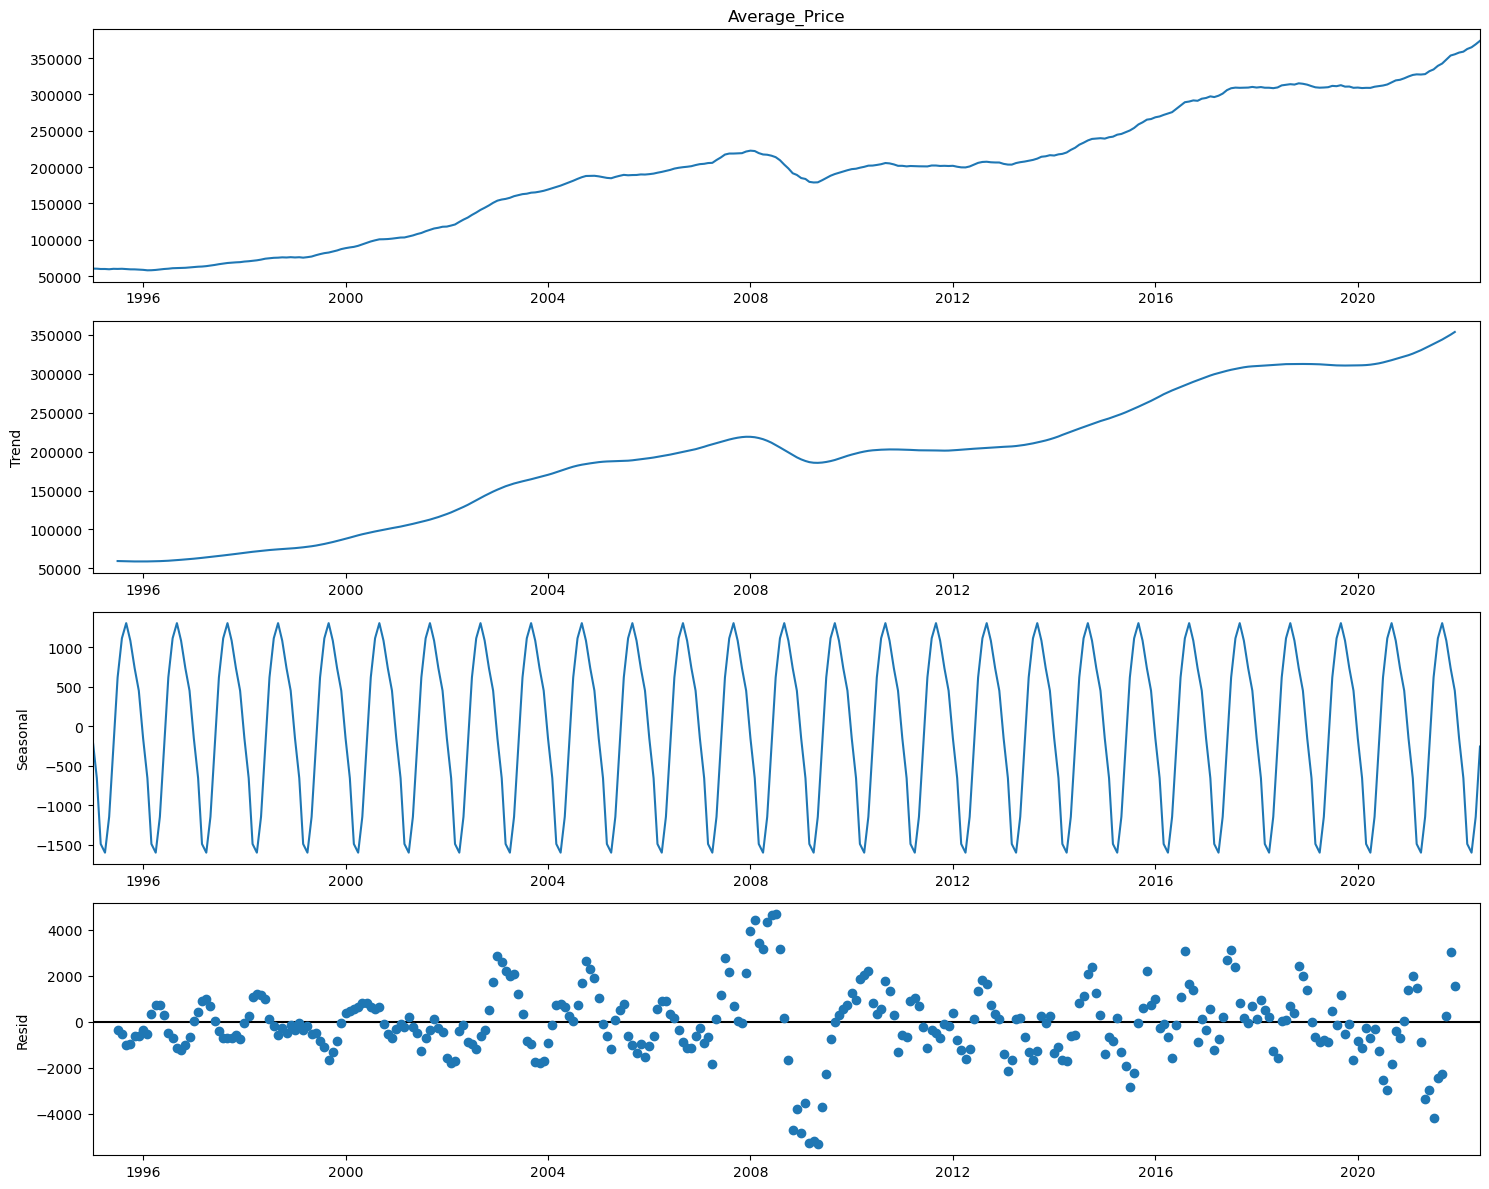

In [ ]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(essex_mean_price, model='additive')
fig = decomposition.plot()
plt.show()

### Prophet

To begin the experiment, leave the data unsplitted.

In [ ]:
# Prepare the data in pandas dataframe
model_df = pd.DataFrame(essex_mean_price).reset_index()
model_df = model_df.rename(columns={'Date': 'ds', 'Average_Price': 'y'})

# Initialise the model and make predictions
m = Prophet()
m.fit(model_df)

future = m.make_future_dataframe(periods=24, freq='M')

forecast = m.predict(future)

# Visualise the prediction
fig1 = m.plot(forecast)

10:27:17 - cmdstanpy - INFO - Chain [1] start processing
10:27:18 - cmdstanpy - INFO - Chain [1] done processing


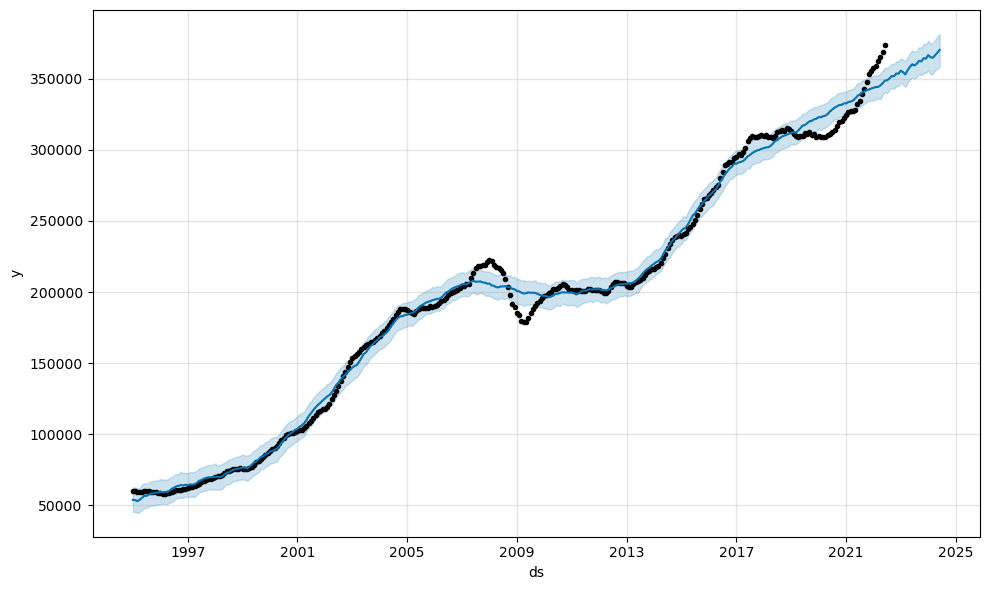

In [ ]:
fig1

In [ ]:
fig2 = m.plot_components(forecast)

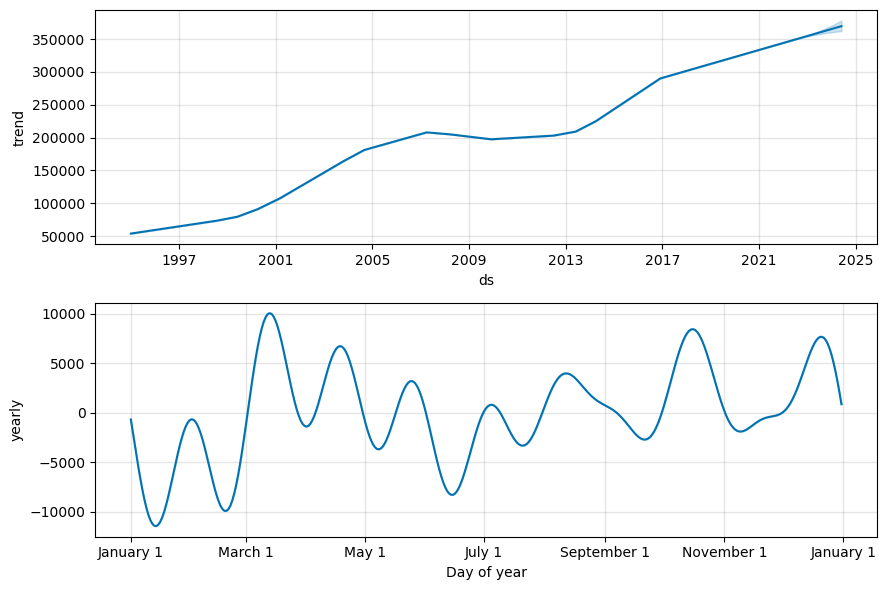

In [ ]:
fig2

In [ ]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1995-01-01,53945.857737,45244.949851,62690.406492,53945.857737,53945.857737,-43.242802,-43.242802,-43.242802,-43.242802,-43.242802,-43.242802,0.0,0.0,0.0,53902.614935
1,1995-02-01,54409.730273,45414.861641,62526.410755,54409.730273,54409.730273,-688.986913,-688.986913,-688.986913,-688.986913,-688.986913,-688.986913,0.0,0.0,0.0,53720.743360
2,1995-03-01,54828.711918,44792.198192,62235.906937,54828.711918,54828.711918,-1841.930377,-1841.930377,-1841.930377,-1841.930377,-1841.930377,-1841.930377,0.0,0.0,0.0,52986.781541
3,1995-04-01,55292.584453,45124.292174,61895.511211,55292.584453,55292.584453,-1367.702838,-1367.702838,-1367.702838,-1367.702838,-1367.702838,-1367.702838,0.0,0.0,0.0,53924.881615
4,1995-05-01,55741.493359,46853.760975,64608.813877,55741.493359,55741.493359,-524.498312,-524.498312,-524.498312,-524.498312,-524.498312,-524.498312,0.0,0.0,0.0,55216.995047


### Forecasting on Split Sets

Now, split data according to selected date.

Example: https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet

In [ ]:
data_reg1.head()

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
96,1995-01-01,Newcastle upon Tyne,E08000021,45235.820312,NaN,NaN,NaN
489,1995-02-01,Newcastle upon Tyne,E08000021,46311.746094,2.378906,NaN,NaN
860,1995-03-01,Newcastle upon Tyne,E08000021,45999.730469,-0.673828,NaN,NaN
1241,1995-04-01,Newcastle upon Tyne,E08000021,46132.507812,0.288574,NaN,NaN
1604,1995-05-01,Newcastle upon Tyne,E08000021,46041.273438,-0.197754,NaN,NaN


In [ ]:
# newcastle_mean_price = data_reg1.groupby('Date')['Average_Price'].max()
# newcastle_mean_price

split_date = '2019-01-01'
newcastle_train = data_reg1.loc[data_reg1["Date"] <= split_date].copy()
newcastle_test = data_reg1.loc[data_reg1["Date"] > split_date].copy()

In [ ]:
newcastle_train.tail()

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
114801,2018-09-01,Newcastle upon Tyne,E08000021,160647.609375,-0.269043,1.667969,NaN
115250,2018-10-01,Newcastle upon Tyne,E08000021,161058.109375,0.255615,1.280273,NaN
115646,2018-11-01,Newcastle upon Tyne,E08000021,161841.156250,0.486084,3.318359,NaN
116089,2018-12-01,Newcastle upon Tyne,E08000021,160976.296875,-0.534180,1.898438,NaN
116496,2019-01-01,Newcastle upon Tyne,E08000021,158458.312500,-1.564453,1.364258,NaN


In [ ]:
newcastle_test.head()

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
116914,2019-02-01,Newcastle upon Tyne,E08000021,155034.656250,-2.160156,-2.078125,NaN
117343,2019-03-01,Newcastle upon Tyne,E08000021,153729.484375,-0.841797,-1.836914,NaN
117752,2019-04-01,Newcastle upon Tyne,E08000021,154293.328125,0.366699,-2.251953,NaN
118203,2019-05-01,Newcastle upon Tyne,E08000021,153264.671875,-0.666504,-2.269531,NaN
118602,2019-06-01,Newcastle upon Tyne,E08000021,155243.437500,1.291016,-2.585938,NaN


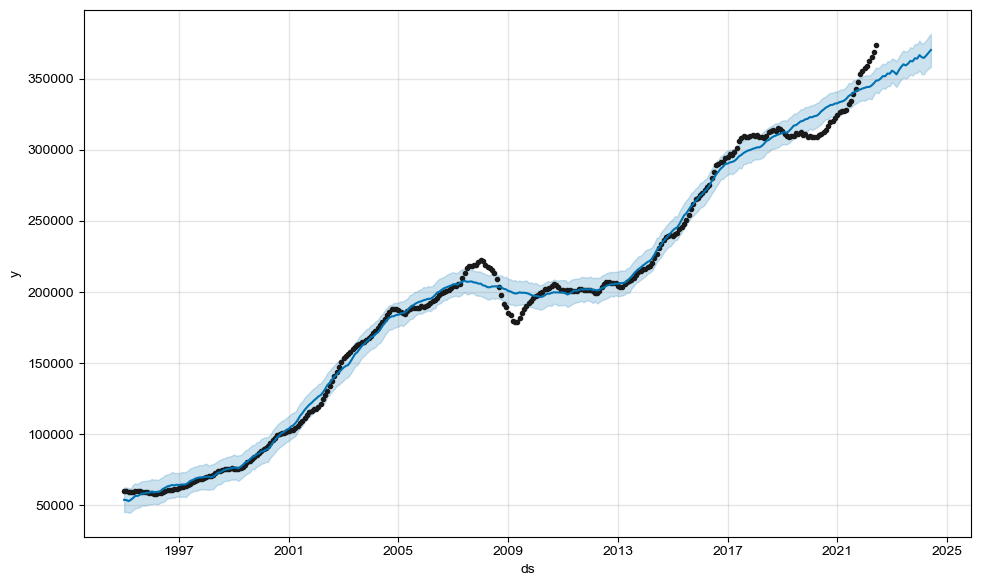

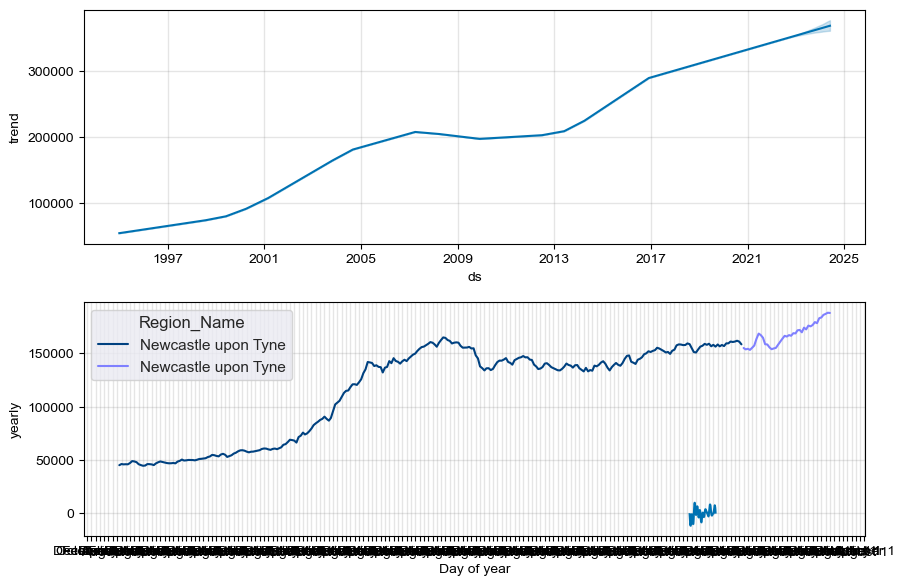

In [ ]:
# Plot the responses for different events and regions
sns.set_theme()
rcParams['figure.figsize'] = 9, 5

sns.lineplot(x="Date", y="Average_Price",
             hue="Region_Name", palette="ocean",
             data=newcastle_train)
sns.lineplot(x="Date", y="Average_Price",
             hue="Region_Name", palette="cool_r",
             data=newcastle_test)
plt.show()

In [ ]:
# Format data for prophet model using ds and y
newcastle_train = newcastle_train[['Date', 'Average_Price']] \
    .rename(columns={'Date':'ds',
                     'Average_Price':'y'})

newcastle_train.head()

,ds,y
96,1995-01-01,45235.820312
489,1995-02-01,46311.746094
860,1995-03-01,45999.730469
1241,1995-04-01,46132.507812
1604,1995-05-01,46041.273438


In [ ]:
model = Prophet()
model.fit(newcastle_train)

10:28:39 - cmdstanpy - INFO - Chain [1] start processing
10:28:39 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
newcastle_test = newcastle_test[['Date', 'Average_Price']] \
    .rename(columns={'Date':'ds',
                     'Average_Price':'y'})

newcastle_forecast = model.predict(newcastle_test)

In [ ]:
newcastle_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-02-01,163889.373228,158217.666377,166536.059004,163889.373228,163889.373228,-1515.273021,-1515.273021,-1515.273021,-1515.273021,-1515.273021,-1515.273021,0.0,0.0,0.0,162374.100207
1,2019-03-01,164220.466395,156081.833822,164187.920280,164220.466395,164220.466395,-4160.702948,-4160.702948,-4160.702948,-4160.702948,-4160.702948,-4160.702948,0.0,0.0,0.0,160059.763447
2,2019-04-01,164587.033830,157679.192473,166195.475316,164537.228149,164648.183801,-2640.563128,-2640.563128,-2640.563128,-2640.563128,-2640.563128,-2640.563128,0.0,0.0,0.0,161946.470702
3,2019-05-01,164941.776509,159903.853808,167978.090967,164803.531682,165109.788982,-1013.352084,-1013.352084,-1013.352084,-1013.352084,-1013.352084,-1013.352084,0.0,0.0,0.0,163928.424424
4,2019-06-01,165308.343943,161700.731828,170134.557659,165046.271610,165628.109017,729.569585,729.569585,729.569585,729.569585,729.569585,729.569585,0.0,0.0,0.0,166037.913528


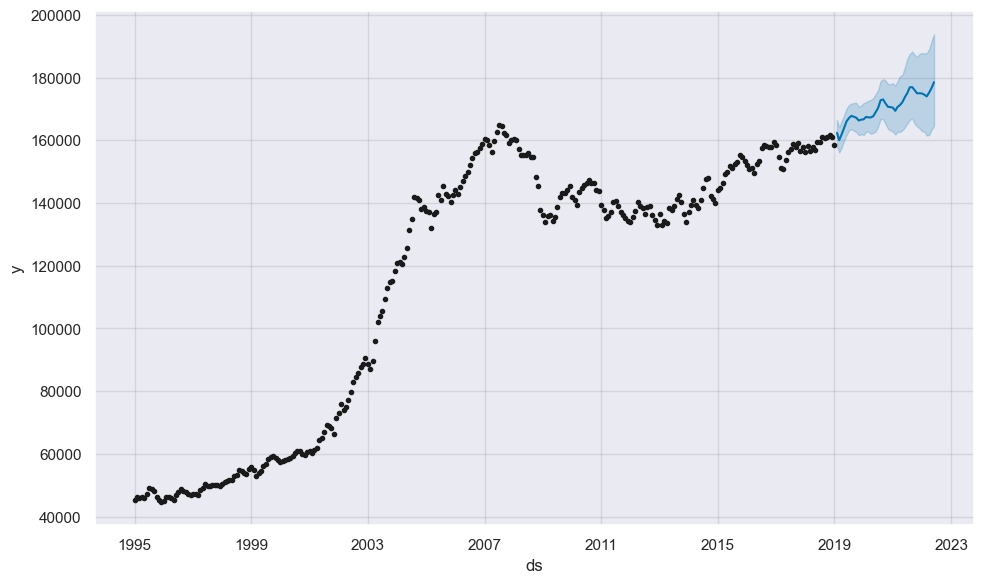

In [ ]:
model.plot(newcastle_forecast)

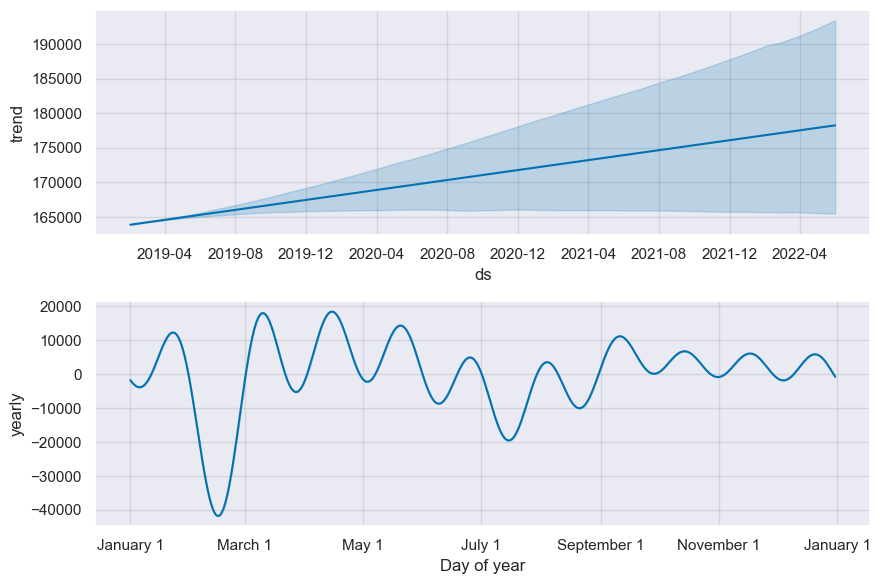

In [ ]:
model.plot_components(newcastle_forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, newcastle_forecast)

In [ ]:
plot_components_plotly(model, newcastle_forecast)

### Other Dataset

In [ ]:
DATA_PATH = os.path.join(NEW_PATH, 'Average-prices-Property-Type-2022-06.csv')
df_property_type = pd.read_csv(DATA_PATH)
df_property_type.head()

,Date,Region_Name,Area_Code,Detached_Average_Price,Detached_Index,Detached_Monthly_Change,Detached_Annual_Change,Semi_Detached_Average_Price,Semi_Detached_Index,Semi_Detached_Monthly_Change,Semi_Detached_Annual_Change,Terraced_Average_Price,Terraced_Index,Terraced_Monthly_Change,Terraced_Annual_Change,Flat_Average_Price,Flat_Index,Flat_Monthly_Change,Flat_Annual_Change
0,1995-01-01,Wales,W92000004,66539.58684,32.491063,NaN,NaN,41043.45436,31.399881,NaN,NaN,32506.88477,30.777231,NaN,NaN,34061.27288,34.448112,NaN,NaN
1,1995-01-01,England,E92000001,86314.15895,28.257874,NaN,NaN,51533.22543,27.436474,NaN,NaN,41489.82431,25.279664,NaN,NaN,45218.54082,23.762969,NaN,NaN
2,1995-01-01,Inner London,E13000001,194483.53650,16.399257,NaN,NaN,121073.17000,15.327414,NaN,NaN,87553.48096,14.627111,NaN,NaN,73707.69351,15.492239,NaN,NaN
3,1995-01-01,Outer London,E13000002,160329.96020,22.303302,NaN,NaN,94802.27143,21.065017,NaN,NaN,70087.65516,20.040752,NaN,NaN,58266.86811,21.764751,NaN,NaN
4,1995-01-01,East Midlands,E12000004,68923.93824,30.745262,NaN,NaN,41227.49644,29.322019,NaN,NaN,32870.49385,28.249263,NaN,NaN,30954.76135,32.880529,NaN,NaN


In [ ]:
df_property_type.describe()

,Detached_Average_Price,Detached_Index,Detached_Monthly_Change,Detached_Annual_Change,Semi_Detached_Average_Price,Semi_Detached_Index,Semi_Detached_Monthly_Change,Semi_Detached_Annual_Change,Terraced_Average_Price,Terraced_Index,Terraced_Monthly_Change,Terraced_Annual_Change,Flat_Average_Price,Flat_Index,Flat_Monthly_Change,Flat_Annual_Change
count,1.310460e+05,131046.000000,130637.000000,126162.000000,1.310580e+05,131058.000000,130649.000000,126174.000000,1.310850e+05,131085.000000,130676.000000,126201.000000,1.313880e+05,131388.000000,130978.000000,126492.000000
mean,2.969736e+05,82.997841,0.522010,6.584939,1.899499e+05,82.405405,0.534053,6.691643,1.505554e+05,81.686067,0.537085,6.743436,1.155765e+05,84.605335,0.462386,5.893356
std,2.585571e+05,33.551756,1.752552,8.122756,1.971536e+05,34.133661,1.739204,8.531800,1.444677e+05,34.332457,1.774742,8.863557,8.880872e+04,32.182639,1.814792,9.268837
min,4.064610e+04,12.494361,-19.628465,-30.193434,2.571306e+04,12.154658,-19.668017,-29.358801,2.045985e+04,11.763214,-19.960934,-29.446217,1.619875e+04,9.865796,-30.295111,-28.871988
25%,1.643284e+05,52.295890,-0.436949,1.740089,1.017824e+05,49.479751,-0.406910,1.745245,7.967255e+04,47.257639,-0.433591,1.604901,6.575568e+04,53.835340,-0.529036,0.211545
50%,2.381102e+05,88.602563,0.508697,5.762455,1.493087e+05,88.931494,0.525463,5.714665,1.201458e+05,89.367739,0.525336,5.722623,9.852217e+04,93.821024,0.439309,4.672682
75%,3.445665e+05,106.065148,1.486397,10.972463,2.187683e+05,106.336685,1.472232,10.846976,1.778945e+05,106.548408,1.504591,10.957866,1.391811e+05,109.721025,1.432592,10.187599
max,4.273773e+06,197.988967,34.812357,92.630423,4.343196e+06,192.327933,35.295354,101.591679,2.859071e+06,217.656918,36.277412,106.853691,1.287157e+06,205.906634,36.067605,102.677794


In [ ]:
df_property_type[df_property_type['Region_Name'] == 'Newcastle upon Tyne']

,Date,Region_Name,Area_Code,Detached_Average_Price,Detached_Index,Detached_Monthly_Change,Detached_Annual_Change,Semi_Detached_Average_Price,Semi_Detached_Index,Semi_Detached_Monthly_Change,Semi_Detached_Annual_Change,Terraced_Average_Price,Terraced_Index,Terraced_Monthly_Change,Terraced_Annual_Change,Flat_Average_Price,Flat_Index,Flat_Monthly_Change,Flat_Annual_Change
94,1995-01-01,Newcastle upon Tyne,E08000021,86545.47276,32.339358,NaN,NaN,50720.57925,31.297834,NaN,NaN,41686.47317,29.815134,NaN,NaN,34918.01291,33.635865,NaN,NaN
484,1995-02-01,Newcastle upon Tyne,E08000021,87898.17329,32.844820,1.562994,NaN,52166.72680,32.190199,2.851205,NaN,42783.47233,30.599734,2.631547,NaN,35594.38061,34.287398,1.937017,NaN
852,1995-03-01,Newcastle upon Tyne,E08000021,87211.65410,32.588289,-0.781039,NaN,51810.20889,31.970205,-0.683420,NaN,42530.84092,30.419046,-0.590488,NaN,35334.70208,34.037254,-0.729549,NaN
1230,1995-04-01,Newcastle upon Tyne,E08000021,87023.77745,32.518085,-0.215426,NaN,51949.83152,32.056361,0.269489,NaN,42684.75292,30.529127,0.361883,NaN,35464.20103,34.161998,0.366492,NaN
1590,1995-05-01,Newcastle upon Tyne,E08000021,86529.92272,32.333547,-0.567494,NaN,51734.03068,31.923198,-0.415402,NaN,42624.43430,30.485986,-0.141312,NaN,35473.72140,34.171169,0.026845,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129450,2022-02-01,Newcastle upon Tyne,E08000021,366502.42510,136.950624,0.307060,13.712680,214095.41170,132.110534,0.422802,10.126761,178784.74250,127.871002,0.482117,7.952048,120907.49770,116.467916,0.386586,5.497694
129880,2022-03-01,Newcastle upon Tyne,E08000021,376364.67770,140.635843,2.690911,14.047449,217177.02220,134.012085,1.439363,9.753440,180498.23760,129.096533,0.958412,7.145718,121575.29010,117.111187,0.552317,4.843612
130295,2022-04-01,Newcastle upon Tyne,E08000021,379832.07650,141.931503,0.921287,14.248302,218017.20510,134.530531,0.386865,10.104479,181798.95360,130.026835,0.720625,7.932397,121570.11850,117.106206,-0.004254,4.563323
130691,2022-05-01,Newcastle upon Tyne,E08000021,381648.42780,142.610217,0.478199,16.124395,219572.02450,135.489954,0.713164,12.164489,183387.10960,131.162721,0.873578,10.310839,121583.97800,117.119556,0.011400,6.158433


In [ ]:
DATA_PATH = os.path.join(NEW_PATH, 'UK-HPI-full-file-2022-06.csv')
df_hpi_full = pd.read_csv(DATA_PATH)
df_hpi_full.head()

,Date,RegionName,AreaCode,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,...,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
0,01/01/2004,Aberdeenshire,S12000034,81693.66964,40.864214,NaN,NaN,NaN,NaN,388.0,...,88436.13953,40.267250,NaN,NaN,103.0,81043.95084,40.883367,NaN,NaN,285.0
1,01/02/2004,Aberdeenshire,S12000034,81678.76231,40.856757,NaN,-0.018248,NaN,NaN,326.0,...,88606.44649,40.344795,0.192576,NaN,107.0,80965.29542,40.843688,-0.097053,NaN,219.0
2,01/03/2004,Aberdeenshire,S12000034,83525.09702,41.780317,NaN,2.260483,NaN,NaN,453.0,...,90296.91375,41.114508,1.907838,NaN,140.0,82903.23948,41.821302,2.393549,NaN,313.0
3,01/04/2004,Aberdeenshire,S12000034,84333.67900,42.184780,NaN,0.968071,NaN,NaN,571.0,...,90319.87844,41.124964,0.025432,NaN,180.0,84003.99161,42.376586,1.327755,NaN,391.0
4,01/05/2004,Aberdeenshire,S12000034,86379.95396,43.208353,NaN,2.426403,NaN,NaN,502.0,...,91989.17763,41.885039,1.848208,NaN,167.0,86222.73484,43.495852,2.641235,NaN,335.0


In [ ]:
df_hpi_full.columns

Index(['Date', 'RegionName', 'AreaCode', 'AveragePrice', 'Index', 'IndexSA',
       '1m%Change', '12m%Change', 'AveragePriceSA', 'SalesVolume',
       'DetachedPrice', 'DetachedIndex', 'Detached1m%Change',
       'Detached12m%Change', 'SemiDetachedPrice', 'SemiDetachedIndex',
       'SemiDetached1m%Change', 'SemiDetached12m%Change', 'TerracedPrice',
       'TerracedIndex', 'Terraced1m%Change', 'Terraced12m%Change', 'FlatPrice',
       'FlatIndex', 'Flat1m%Change', 'Flat12m%Change', 'CashPrice',
       'CashIndex', 'Cash1m%Change', 'Cash12m%Change', 'CashSalesVolume',
       'MortgagePrice', 'MortgageIndex', 'Mortgage1m%Change',
       'Mortgage12m%Change', 'MortgageSalesVolume', 'FTBPrice', 'FTBIndex',
       'FTB1m%Change', 'FTB12m%Change', 'FOOPrice', 'FOOIndex', 'FOO1m%Change',
       'FOO12m%Change', 'NewPrice', 'NewIndex', 'New1m%Change',
       'New12m%Change', 'NewSalesVolume', 'OldPrice', 'OldIndex',
       'Old1m%Change', 'Old12m%Change', 'OldSalesVolume'],
      dtype='object

In [ ]:
df_hpi_full.describe()

,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,DetachedPrice,DetachedIndex,Detached1m%Change,...,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
count,1.373550e+05,137355.000000,4614.000000,136912.000000,132315.000000,4614.000000,132856.000000,1.310460e+05,131046.000000,130637.000000,...,1.305570e+05,130557.000000,130147.000000,125661.000000,130208.000000,1.305680e+05,130568.000000,130158.000000,125672.000000,130558.000000
mean,1.683608e+05,81.481919,84.047956,0.578437,6.632173,158859.279814,1216.372376,2.969736e+05,82.997841,0.522010,...,2.015712e+05,83.486748,0.574018,6.924745,127.472262,1.697732e+05,81.983102,0.515034,6.508353,1104.046899
std,1.136484e+05,35.230453,32.480104,1.990798,8.917611,82419.182117,7590.412858,2.585571e+05,33.551756,1.752552,...,1.191276e+05,34.968303,1.846893,8.570993,812.677423,1.126009e+05,33.237706,1.781768,8.672196,6869.117511
min,2.712016e+03,1.096815,18.312610,-30.297781,-35.786566,40405.313840,2.000000,4.064610e+04,12.494361,-19.628465,...,2.722990e+04,9.708894,-29.816368,-28.851244,0.000000,2.278638e+04,10.097461,-30.587732,-30.341125,2.000000
25%,9.452547e+04,47.081958,57.745553,-0.423326,1.526205,110191.174650,139.000000,1.643284e+05,52.295890,-0.436949,...,1.217405e+05,51.520538,-0.445320,1.887913,9.000000,9.752786e+04,49.733040,-0.439721,1.436548,125.000000
50%,1.475496e+05,89.126580,90.433810,0.535355,5.655216,149161.415550,214.000000,2.381102e+05,88.602563,0.508697,...,1.842147e+05,88.867814,0.552242,5.874553,20.000000,1.482705e+05,89.303695,0.503567,5.534956,192.000000
75%,2.109951e+05,106.735562,106.993467,1.522046,10.867958,195021.951625,373.000000,3.445665e+05,106.065148,1.486397,...,2.506479e+05,106.755263,1.573860,11.504256,44.000000,2.106429e+05,106.086147,1.465454,10.677829,337.000000
max,1.463378e+06,221.485238,158.535432,35.286646,98.437940,536185.231400,165290.000000,4.273773e+06,197.988967,34.812357,...,1.387585e+06,210.729928,34.946588,96.170727,21097.333330,1.479584e+06,207.478740,35.552952,98.648458,156074.000000


In [ ]:
df_hpi_full[df_hpi_full['RegionName'] == 'Newcastle upon Tyne']

,Date,RegionName,AreaCode,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,...,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
75738,01/01/1995,Newcastle upon Tyne,E08000021,45235.82000,31.409810,NaN,NaN,NaN,NaN,215.0,...,62616.20180,31.373112,NaN,NaN,18.0,44077.88531,31.511715,NaN,NaN,197.0
75739,01/02/1995,Newcastle upon Tyne,E08000021,46311.74615,32.156887,NaN,2.378483,NaN,NaN,194.0,...,64320.78452,32.227173,2.722271,NaN,19.0,45108.59854,32.248582,2.338391,NaN,175.0
75740,01/03/1995,Newcastle upon Tyne,E08000021,45999.73185,31.940238,NaN,-0.673726,NaN,NaN,319.0,...,64129.34977,32.131257,-0.297625,NaN,38.0,44784.94943,32.017202,-0.717489,NaN,281.0
75741,01/04/1995,Newcastle upon Tyne,E08000021,46132.50813,32.032432,NaN,0.288646,NaN,NaN,244.0,...,64216.96407,32.175155,0.136621,NaN,20.0,44922.27146,32.115375,0.306625,NaN,224.0
75742,01/05/1995,Newcastle upon Tyne,E08000021,46041.27433,31.969083,NaN,-0.197765,NaN,NaN,260.0,...,63926.50331,32.029623,-0.452312,NaN,26.0,44846.85742,32.061460,-0.167877,NaN,234.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76063,01/02/2022,Newcastle upon Tyne,E08000021,183665.95710,127.529755,NaN,0.398401,8.874150,NaN,202.0,...,291106.83080,145.855815,1.425563,17.461498,4.0,175222.00520,125.267933,0.425993,7.424837,198.0
76064,01/03/2022,Newcastle upon Tyne,E08000021,186039.01080,129.177502,NaN,1.292049,8.424059,NaN,255.0,...,307345.12960,153.991832,5.578124,19.709118,1.0,176655.92100,126.293053,0.818342,6.829030,254.0
76065,01/04/2022,Newcastle upon Tyne,E08000021,186972.24740,129.825501,NaN,0.501635,8.747797,NaN,173.0,...,313475.06080,157.063165,1.994478,20.014173,0.0,177305.56760,126.757492,0.367747,7.358681,173.0
76066,01/05/2022,Newcastle upon Tyne,E08000021,188063.60080,130.583290,NaN,0.583698,10.795535,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
DATA_PATH = os.path.join(NEW_PATH, 'New-and-Old-2022-06.csv')
df_new_and_old = pd.read_csv(DATA_PATH)
df_new_and_old.head()

,Date,Region_Name,Area_Code,New_Build_Average_Price,New_Build_Index,New_Build_Monthly_Change,New_Build_Annual_Change,New_Build_Sales_Volume,Existing_Property_Average_Price,Existing_Property_Index,Existing_Property_Monthly_Change,Existing_Property_Annual_Change,Existing_Property_Sales_Volume
0,1995-01-01,Wales,W92000004,56129.76716,32.456426,NaN,NaN,225.0,42348.42981,31.621249,NaN,NaN,1766.0
1,1995-01-01,England,E92000001,64657.42486,26.477230,NaN,NaN,5308.0,52440.59891,26.214391,NaN,NaN,42331.0
2,1995-01-01,Inner London,E13000001,74246.49589,15.201567,NaN,NaN,282.0,78661.30981,15.264684,NaN,NaN,2608.0
3,1995-01-01,Outer London,E13000002,70923.52747,20.629968,NaN,NaN,343.0,72865.04024,20.871492,NaN,NaN,4273.0
4,1995-01-01,East Midlands,E12000004,57761.56145,28.803211,NaN,NaN,542.0,44695.55186,29.770413,NaN,NaN,3448.0


In [ ]:
df_new_and_old.describe()

,New_Build_Average_Price,New_Build_Index,New_Build_Monthly_Change,New_Build_Annual_Change,New_Build_Sales_Volume,Existing_Property_Average_Price,Existing_Property_Index,Existing_Property_Monthly_Change,Existing_Property_Annual_Change,Existing_Property_Sales_Volume
count,1.305570e+05,130557.000000,130147.000000,125661.000000,130208.000000,1.305680e+05,130568.000000,130158.000000,125672.000000,130558.000000
mean,2.015712e+05,83.486748,0.574018,6.924745,127.472262,1.697732e+05,81.983102,0.515034,6.508353,1104.046899
std,1.191276e+05,34.968303,1.846893,8.570993,812.677423,1.126009e+05,33.237706,1.781768,8.672196,6869.117511
min,2.722990e+04,9.708894,-29.816368,-28.851244,0.000000,2.278638e+04,10.097461,-30.587732,-30.341125,2.000000
25%,1.217405e+05,51.520538,-0.445320,1.887913,9.000000,9.752786e+04,49.733040,-0.439721,1.436548,125.000000
50%,1.842147e+05,88.867814,0.552242,5.874553,20.000000,1.482705e+05,89.303695,0.503567,5.534956,192.000000
75%,2.506479e+05,106.755263,1.573860,11.504256,44.000000,2.106429e+05,106.086147,1.465454,10.677829,337.000000
max,1.387585e+06,210.729928,34.946588,96.170727,21097.333330,1.479584e+06,207.478740,35.552952,98.648458,156074.000000


In [ ]:
df_new_and_old[df_new_and_old['Region_Name'] == 'Newcastle upon Tyne']


,Date,Region_Name,Area_Code,New_Build_Average_Price,New_Build_Index,New_Build_Monthly_Change,New_Build_Annual_Change,New_Build_Sales_Volume,Existing_Property_Average_Price,Existing_Property_Index,Existing_Property_Monthly_Change,Existing_Property_Annual_Change,Existing_Property_Sales_Volume
94,1995-01-01,Newcastle upon Tyne,E08000021,62616.20180,31.373112,NaN,NaN,18.0,44077.88531,31.511715,NaN,NaN,197.0
484,1995-02-01,Newcastle upon Tyne,E08000021,64320.78452,32.227173,2.722271,NaN,19.0,45108.59854,32.248582,2.338391,NaN,175.0
852,1995-03-01,Newcastle upon Tyne,E08000021,64129.34977,32.131257,-0.297625,NaN,38.0,44784.94943,32.017202,-0.717489,NaN,281.0
1230,1995-04-01,Newcastle upon Tyne,E08000021,64216.96407,32.175155,0.136621,NaN,20.0,44922.27146,32.115375,0.306625,NaN,224.0
1590,1995-05-01,Newcastle upon Tyne,E08000021,63926.50331,32.029623,-0.452312,NaN,26.0,44846.85742,32.061460,-0.167877,NaN,234.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130901,2021-12-01,Newcastle upon Tyne,E08000021,281332.28500,140.958388,-0.640661,18.179796,35.0,169833.42160,121.415581,-0.544686,5.021874,304.0
131313,2022-01-01,Newcastle upon Tyne,E08000021,287015.24780,143.805773,2.020018,17.473124,0.0,174478.73810,124.736564,2.735219,6.582619,174.0
131716,2022-02-01,Newcastle upon Tyne,E08000021,291106.83080,145.855815,1.425563,17.461498,4.0,175222.00520,125.267933,0.425993,7.424837,198.0
132157,2022-03-01,Newcastle upon Tyne,E08000021,307345.12960,153.991832,5.578124,19.709118,1.0,176655.92100,126.293053,0.818342,6.829030,254.0


### Combining dataset on Region Name `Newcastle upon Tyne`

In [ ]:
df_new_and_old[df_new_and_old['Region_Name'] == 'Newcastle upon Tyne']
df_hpi_full[df_hpi_full['RegionName'] == 'Newcastle upon Tyne']
df_property_type[df_property_type['Region_Name'] == 'Newcastle upon Tyne']


In [ ]:
df_new_and_old.columns

Index(['Date', 'Region_Name', 'Area_Code', 'New_Build_Average_Price',
       'New_Build_Index', 'New_Build_Monthly_Change',
       'New_Build_Annual_Change', 'New_Build_Sales_Volume',
       'Existing_Property_Average_Price', 'Existing_Property_Index',
       'Existing_Property_Monthly_Change', 'Existing_Property_Annual_Change',
       'Existing_Property_Sales_Volume'],
      dtype='object')

In [ ]:
df_hpi_full.columns

Index(['Date', 'RegionName', 'AreaCode', 'AveragePrice', 'Index', 'IndexSA',
       '1m%Change', '12m%Change', 'AveragePriceSA', 'SalesVolume',
       'DetachedPrice', 'DetachedIndex', 'Detached1m%Change',
       'Detached12m%Change', 'SemiDetachedPrice', 'SemiDetachedIndex',
       'SemiDetached1m%Change', 'SemiDetached12m%Change', 'TerracedPrice',
       'TerracedIndex', 'Terraced1m%Change', 'Terraced12m%Change', 'FlatPrice',
       'FlatIndex', 'Flat1m%Change', 'Flat12m%Change', 'CashPrice',
       'CashIndex', 'Cash1m%Change', 'Cash12m%Change', 'CashSalesVolume',
       'MortgagePrice', 'MortgageIndex', 'Mortgage1m%Change',
       'Mortgage12m%Change', 'MortgageSalesVolume', 'FTBPrice', 'FTBIndex',
       'FTB1m%Change', 'FTB12m%Change', 'FOOPrice', 'FOOIndex', 'FOO1m%Change',
       'FOO12m%Change', 'NewPrice', 'NewIndex', 'New1m%Change',
       'New12m%Change', 'NewSalesVolume', 'OldPrice', 'OldIndex',
       'Old1m%Change', 'Old12m%Change', 'OldSalesVolume'],
      dtype='object

In [ ]:
df_property_type.columns

Index(['Date', 'Region_Name', 'Area_Code', 'Detached_Average_Price',
       'Detached_Index', 'Detached_Monthly_Change', 'Detached_Annual_Change',
       'Semi_Detached_Average_Price', 'Semi_Detached_Index',
       'Semi_Detached_Monthly_Change', 'Semi_Detached_Annual_Change',
       'Terraced_Average_Price', 'Terraced_Index', 'Terraced_Monthly_Change',
       'Terraced_Annual_Change', 'Flat_Average_Price', 'Flat_Index',
       'Flat_Monthly_Change', 'Flat_Annual_Change'],
      dtype='object')

In [ ]:
hpi_newcastle = df_hpi_full[df_hpi_full['RegionName'] == 'Newcastle upon Tyne']
hpi_newcastle['Date'] = pd.to_datetime(hpi_newcastle['Date']).dt.strftime('%Y-%d-%m')
hpi_newcastle.head()


<ipython-input-84-ab7c9f52d52d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,RegionName,AreaCode,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,...,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
75738,1995-01-01,Newcastle upon Tyne,E08000021,45235.82000,31.409810,NaN,NaN,NaN,NaN,215.0,...,62616.20180,31.373112,NaN,NaN,18.0,44077.88531,31.511715,NaN,NaN,197.0
75739,1995-02-01,Newcastle upon Tyne,E08000021,46311.74615,32.156887,NaN,2.378483,NaN,NaN,194.0,...,64320.78452,32.227173,2.722271,NaN,19.0,45108.59854,32.248582,2.338391,NaN,175.0
75740,1995-03-01,Newcastle upon Tyne,E08000021,45999.73185,31.940238,NaN,-0.673726,NaN,NaN,319.0,...,64129.34977,32.131257,-0.297625,NaN,38.0,44784.94943,32.017202,-0.717489,NaN,281.0
75741,1995-04-01,Newcastle upon Tyne,E08000021,46132.50813,32.032432,NaN,0.288646,NaN,NaN,244.0,...,64216.96407,32.175155,0.136621,NaN,20.0,44922.27146,32.115375,0.306625,NaN,224.0
75742,1995-05-01,Newcastle upon Tyne,E08000021,46041.27433,31.969083,NaN,-0.197765,NaN,NaN,260.0,...,63926.50331,32.029623,-0.452312,NaN,26.0,44846.85742,32.061460,-0.167877,NaN,234.0


In [ ]:
hpi_newcastle.loc[hpi_newcastle['Date'].between('2018-12-31','2019-12-31', inclusive=False)]

,Date,RegionName,AreaCode,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,...,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
76026,2019-01-01,Newcastle upon Tyne,E08000021,158458.3144,110.026651,NaN,-1.564196,1.364693,NaN,250.0,...,226368.4578,113.419378,-1.566907,1.975220,15.0,153552.6479,109.776296,-1.563720,1.422404,235.0
76027,2019-02-01,Newcastle upon Tyne,E08000021,155034.6514,107.649406,NaN,-2.160608,-2.077495,NaN,251.0,...,226489.0905,113.479820,0.053290,-1.332239,27.0,149798.7282,107.092582,-2.444712,-2.076150,224.0
76028,2019-03-01,Newcastle upon Tyne,E08000021,153729.4845,106.743154,NaN,-0.841855,-1.836825,NaN,290.0,...,226954.0086,113.712762,0.205272,-0.360302,60.0,148322.5022,106.037214,-0.985473,-1.990808,230.0
76029,2019-04-01,Newcastle upon Tyne,E08000021,154293.3229,107.134659,NaN,0.366773,-2.252790,NaN,273.0,...,229021.9225,114.748867,0.911160,-0.283756,40.0,148779.2296,106.363733,0.307929,-2.457263,233.0
76030,2019-05-01,Newcastle upon Tyne,E08000021,153264.6671,106.420405,NaN,-0.666688,-2.269033,NaN,309.0,...,224886.9414,112.677081,-1.805496,0.301214,29.0,147969.7687,105.785041,-0.544068,-2.618154,280.0
76031,2019-06-01,Newcastle upon Tyne,E08000021,155243.4325,107.794375,NaN,1.291077,-2.585141,NaN,361.0,...,225283.8595,112.875953,0.176497,-0.996983,73.0,150059.5350,107.279036,1.412293,-2.836422,288.0
76032,2019-07-01,Newcastle upon Tyne,E08000021,157349.5417,109.256766,NaN,1.356649,-1.285470,NaN,315.0,...,228477.4652,114.476073,1.417592,0.821079,52.0,152085.6455,108.727522,1.350204,-1.612364,263.0
76033,2019-08-01,Newcastle upon Tyne,E08000021,163608.8187,113.602940,NaN,3.977944,1.569377,NaN,349.0,...,236628.0043,118.559809,3.567327,2.636943,38.0,158202.7715,113.100715,4.022159,1.381883,311.0
76034,2019-09-01,Newcastle upon Tyne,E08000021,168533.3009,117.022289,NaN,3.009912,4.908689,NaN,310.0,...,245314.6990,122.912180,3.671034,6.621093,43.0,162851.7523,116.424317,2.938622,4.653468,267.0
76035,2019-10-01,Newcastle upon Tyne,E08000021,167109.4602,116.033635,NaN,-0.844842,3.757243,NaN,317.0,...,242673.9351,121.589055,-1.076480,4.657015,49.0,161515.8160,115.469243,-0.820339,3.614473,268.0


In [ ]:
df_hpi_full['Date'] = pd.to_datetime(df_hpi_full['Date']).dt.strftime('%Y-%d-%m')
df_hpi_full[df_hpi_full['Date'].str[:4].isin(['1995'])].head()

,Date,RegionName,AreaCode,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,...,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
222,1995-01-01,Adur,E07000223,54516.42545,21.836620,NaN,NaN,NaN,NaN,79.0,...,59255.49943,22.378461,NaN,NaN,11.0,54372.37389,21.788639,NaN,NaN,68.0
223,1995-02-01,Adur,E07000223,55708.33312,22.314040,NaN,2.186328,NaN,NaN,69.0,...,60654.01325,22.906624,2.360142,NaN,5.0,55557.42782,22.263526,2.179515,NaN,64.0
224,1995-03-01,Adur,E07000223,55724.54586,22.320534,NaN,0.029103,NaN,NaN,103.0,...,60835.22587,22.975061,0.298764,NaN,5.0,55567.73779,22.267657,0.018557,NaN,98.0
225,1995-04-01,Adur,E07000223,55440.83646,22.206894,NaN,-0.509128,NaN,NaN,84.0,...,60471.94043,22.837862,-0.597163,NaN,2.0,55286.75938,22.155061,-0.505650,NaN,82.0
226,1995-05-01,Adur,E07000223,53334.35175,21.363139,NaN,-3.799518,NaN,NaN,77.0,...,58206.71489,21.982376,-3.745912,NaN,5.0,53184.96713,21.312810,-3.801620,NaN,72.0


In [ ]:
removed_cols = ['IndexSA', 'AveragePriceSA', 
       'DetachedIndex', 'Detached1m%Change', 'Detached12m%Change', 
       'SemiDetachedIndex', 'SemiDetached1m%Change', 'SemiDetached12m%Change', 
       'TerracedIndex', 'Terraced1m%Change', 'Terraced12m%Change', 
       'FlatIndex', 'Flat1m%Change', 'Flat12m%Change', 
       'CashIndex', 'Cash1m%Change', 'Cash12m%Change', 'CashSalesVolume',
       'MortgageIndex', 'Mortgage1m%Change', 'Mortgage12m%Change', 'MortgageSalesVolume', 
       'FTBPrice', 'FTBIndex', 'FTB1m%Change', 'FTB12m%Change', 
       'FOOPrice', 'FOOIndex', 'FOO1m%Change', 'FOO12m%Change', 
       'NewIndex', 'New1m%Change', 'New12m%Change', 'NewSalesVolume', 
       'OldIndex', 'Old1m%Change', 'Old12m%Change', 'OldSalesVolume']

def remove_columns(dataset,cols):
    return dataset.drop(cols, axis=1)

df_hpi_full = remove_columns(df_hpi_full, removed_cols)

In [ ]:
df_hpi_full.head()

,Date,RegionName,AreaCode,AveragePrice,Index,1m%Change,12m%Change,SalesVolume,DetachedPrice,SemiDetachedPrice,TerracedPrice,FlatPrice,CashPrice,MortgagePrice,NewPrice,OldPrice
0,2004-01-01,Aberdeenshire,S12000034,81693.66964,40.864214,NaN,NaN,388.0,122490.0641,70563.15784,55319.63336,48016.07412,NaN,NaN,88436.13953,81043.95084
1,2004-02-01,Aberdeenshire,S12000034,81678.76231,40.856757,-0.018248,NaN,326.0,121280.8840,70804.42408,55720.07531,49030.18133,NaN,NaN,88606.44649,80965.29542
2,2004-03-01,Aberdeenshire,S12000034,83525.09702,41.780317,2.260483,NaN,453.0,123395.4269,72689.07253,57362.85925,50349.44771,NaN,NaN,90296.91375,82903.23948
3,2004-04-01,Aberdeenshire,S12000034,84333.67900,42.184780,0.968071,NaN,571.0,122334.0258,74484.23119,59193.39722,51736.22329,NaN,NaN,90319.87844,84003.99161
4,2004-05-01,Aberdeenshire,S12000034,86379.95396,43.208353,2.426403,NaN,502.0,124498.8747,76637.73414,61202.79629,53230.23061,NaN,NaN,91989.17763,86222.73484


In [ ]:
df_hpi_full = remove_columns(df_hpi_full, ['1m%Change','12m%Change'])

In [21]:
df_hpi_full[df_hpi_full['Date'].str[:4].isin(['1995'])].head()

,Date,RegionName,AreaCode,AveragePrice,Index,SalesVolume,DetachedPrice,SemiDetachedPrice,TerracedPrice,FlatPrice,CashPrice,MortgagePrice,NewPrice,OldPrice
222,1995-01-01,Adur,E07000223,54516.42545,21.836620,79.0,85482.01252,59598.67451,48955.96381,38126.03274,NaN,NaN,59255.49943,54372.37389
223,1995-02-01,Adur,E07000223,55708.33312,22.314040,69.0,86608.15652,61135.57058,50152.49854,38788.83933,NaN,NaN,60654.01325,55557.42782
224,1995-03-01,Adur,E07000223,55724.54586,22.320534,103.0,86386.66096,61125.69506,50266.10542,38801.15471,NaN,NaN,60835.22587,55567.73779
225,1995-04-01,Adur,E07000223,55440.83646,22.206894,84.0,85566.09671,60824.13245,50102.15940,38616.39860,NaN,NaN,60471.94043,55286.75938
226,1995-05-01,Adur,E07000223,53334.35175,21.363139,77.0,82340.96480,58475.66019,48175.79230,37213.06360,NaN,NaN,58206.71489,53184.96713


In [14]:
df_hpi_full[df_hpi_full['RegionName'] == 'Oxford']

,Date,RegionName,AreaCode,AveragePrice,Index,SalesVolume,DetachedPrice,SemiDetachedPrice,TerracedPrice,FlatPrice,CashPrice,MortgagePrice,NewPrice,OldPrice
86208,1995-01-01,Oxford,E07000178,78024.87998,22.177579,90.0,164710.3296,93720.04694,71763.63902,58506.90653,NaN,NaN,64500.01786,78573.26130
86209,1995-02-01,Oxford,E07000178,77770.11164,22.105165,94.0,162058.2129,93629.68408,71561.07316,58340.99795,NaN,NaN,64697.04874,78205.52361
86210,1995-03-01,Oxford,E07000178,76013.83372,21.605965,128.0,158048.5942,91538.18439,70086.10671,56859.07264,NaN,NaN,63194.68009,76450.56212
86211,1995-04-01,Oxford,E07000178,74908.72866,21.291853,145.0,154696.3041,90209.64176,69155.42596,56112.24462,NaN,NaN,62245.70302,75347.43909
86212,1995-05-01,Oxford,E07000178,73923.63910,21.011854,137.0,152659.4788,89044.20778,68306.21704,55257.89624,NaN,NaN,61242.65607,74406.77559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86533,2022-02-01,Oxford,E07000178,460257.78150,130.822419,64.0,952811.6523,586428.41530,455284.75920,290387.48240,461529.0861,459276.6727,407882.23860,461558.97230
86534,2022-03-01,Oxford,E07000178,469267.13910,133.383214,90.0,972953.9415,599281.64250,464109.23010,294945.68860,469731.9076,468601.5368,433455.22570,470083.66420
86535,2022-04-01,Oxford,E07000178,458162.54680,130.226875,91.0,950171.5074,584227.42030,454330.59970,287207.14080,458234.6381,457664.8310,432035.90390,458750.94420
86536,2022-05-01,Oxford,E07000178,468381.98760,133.131621,NaN,971094.3140,598194.29390,465410.03020,291791.77050,468138.3003,467999.7865,NaN,NaN


In [22]:
df_hpi_full.to_csv('Average_HPI-2022-06_from1995.csv')

In [32]:
col1 = ["AveragePrice", "DetachedPrice", "SemiDetachedPrice", "TerracedPrice", 
        "FlatPrice", "CashPrice", "MortgagePrice", "NewPrice", "OldPrice"]


DATA_PATH = os.path.join(NEW_PATH, 'Average_HPI-2022-06_from1995.csv')
df3 = pd.read_csv(DATA_PATH)
df3 = df3.drop("Unnamed: 0", axis=1)
df3["Date"] = pd.to_datetime(df3.Date)
df3[col1] = df3[col1].astype("float32")

df3.head()

,Date,RegionName,AreaCode,AveragePrice,Index,SalesVolume,DetachedPrice,SemiDetachedPrice,TerracedPrice,FlatPrice,CashPrice,MortgagePrice,NewPrice,OldPrice
0,2004-01-01,Aberdeenshire,S12000034,81693.671875,40.864214,388.0,122490.062500,70563.156250,55319.632812,48016.074219,NaN,NaN,88436.140625,81043.953125
1,2004-02-01,Aberdeenshire,S12000034,81678.765625,40.856757,326.0,121280.882812,70804.421875,55720.074219,49030.179688,NaN,NaN,88606.445312,80965.296875
2,2004-03-01,Aberdeenshire,S12000034,83525.093750,41.780317,453.0,123395.429688,72689.070312,57362.859375,50349.449219,NaN,NaN,90296.914062,82903.242188
3,2004-04-01,Aberdeenshire,S12000034,84333.679688,42.184780,571.0,122334.023438,74484.234375,59193.398438,51736.222656,NaN,NaN,90319.875000,84003.992188
4,2004-05-01,Aberdeenshire,S12000034,86379.953125,43.208353,502.0,124498.875000,76637.734375,61202.796875,53230.230469,NaN,NaN,91989.179688,86222.734375
